In [1]:
from nltk.corpus import gutenberg
from nltk.tokenize import regexp_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk


from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score



from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


nltk.download('stopwords')
nltk.download('gutenberg')
nltk.download('punkt')
nltk.download('wordnet')
from nltk import ngrams
stop_words = set(stopwords.words('english'))
import re
import random
import pandas as pd

import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel
from keras_preprocessing.sequence import pad_sequences
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [34]:
pip install keras_preprocessing


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
!pip install simpletransformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# obtain the list of books by using .fileids() function.
listBooks = gutenberg.fileids()
listBooks

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [7]:
genre_books={}

# Get the author names and book titles for each drama book
for book in listBooks:
    # Extract the author name from the felid
    author_line = gutenberg.raw(book).split('\n')[0]
    author_name = author_line.split("by", 1)[-1].strip().replace("]", "").replace("by","")
    # Remove the year from the author name using regular expressions
    author_name = re.sub(r'\b\d{4}\b', '', author_name).strip()

    # Extract the book title from the felid
    title =book.split('/')[-1]
    
    # Check if the book is related to drama
    if 'history' in nltk.corpus.gutenberg.raw(book).lower():
      genre_books[title]=author_name

genre_books

{'austen-emma.txt': 'Jane Austen',
 'austen-persuasion.txt': 'Jane Austen',
 'austen-sense.txt': 'Jane Austen',
 'carroll-alice.txt': 'Lewis Carroll',
 'chesterton-ball.txt': 'G.K. Chesterton',
 'chesterton-brown.txt': 'G. K. Chesterton',
 'chesterton-thursday.txt': 'G. K. Chesterton',
 'edgeworth-parents.txt': 'Maria Edgeworth',
 'melville-moby_dick.txt': 'Dick  Herman Melville',
 'shakespeare-caesar.txt': 'William Shakespeare',
 'shakespeare-hamlet.txt': 'William Shakespeare',
 'whitman-leaves.txt': 'Walt Whitman'}

In [8]:
selected_books = []

#Get five differnet books with five differnet authors
def get_books(numberBooks):
    authors = set()

    while len(selected_books) < numberBooks:
        title, author = random.choice(list(genre_books.items()))
        if author not in authors:
            authors.add(author)
            selected_books.append(title)

    return selected_books
get_books(5)

['shakespeare-caesar.txt',
 'melville-moby_dick.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'austen-emma.txt']

In [9]:
#label books Names with a unique label (even if there are more than 26 book)(book 27->aa)(book 28 -->ab)
book_map = {}
for i, book_name in enumerate(selected_books):
    label = chr(ord('a') + i)
    book_map[book_name] = label

In [10]:
def clean_text(text):

    #remove punctuation and strange characters
    lemmatizer = WordNetLemmatizer()
    sub_pattern = r'[^A-Za-z]'
    split_pattern = r"\s+"

    #remove stop words
    stop_words = stopwords.words('english') + ['never','ever','couldnot','wouldnot','could','would','us',"i'm","you'd"]

    # Converting all words into lower case.
    lower_book = text.lower()        

    # Replacing all characters except those in the pattern into spaces.                                      
    filtered_book = re.sub(sub_pattern,' ',lower_book).lstrip().rstrip() 

     # tokenizethe whole book into words in a list.
    filtered_book = word_tokenize(filtered_book)                     
    filtered_book = [lemmatizer.lemmatize(word) for word in filtered_book if word not in stop_words]

    return filtered_book

In [11]:
def pepareBook():
    Partitons_num=200
    num_of_words=100

    df = pd.DataFrame(columns=["Partitions","Book Name","Book Label","Book Author"])
   
    for id,book in enumerate(selected_books):
        
        # import data from Gutenberg by using .raw() function
        raw_text = gutenberg.raw(book)

        print(len(raw_text))

        #clean book Text
        cleaned_book= clean_text(raw_text)

        print(len(cleaned_book))

        # tokenization of words (more then 3 chars ) by using word_tokenize() function.
        tokens = nltk.regexp_tokenize(str(cleaned_book), r'\w{3,}')
        data_Partition=[]
       
        # create (Partitons_num) random sample of number of words for each book.
        # use for loop
        for i in range(Partitons_num):
            
            # Use random.randint() function to randomly pick a start position for selecting the 150 words
            # Select num_of_word words from the start position
            start_pos = random.randint(0, len(tokens) - num_of_words)
      
            # divide the tokenized words into partitions and label the partitions
            partitions_tokens = tokens[start_pos:start_pos + num_of_words]

            #join all tokens in one sentence
            partitions = ' '.join(partitions_tokens)

            #data frame prepartion
            
            bookName = book.split('-')[1].capitalize()
            bookLabel=book_map[book]
            bookAuthor= genre_books[book]
           

            # use append function to label each Partion to the corresponding label (e.g., author name)
            df.loc[len(df)] = [partitions,bookName, bookLabel, bookAuthor]
    return df

In [12]:
df=pepareBook()
df

112310
10989
1242990
109121
457450
39224
406629
34882
887071
70793


,Partitions,Book Name,Book Label,Book Author
0,vile loue countrey speake haue offended pause ...,Caesar.txt,a,William Shakespeare
1,shall contaminate finger base bribe sell might...,Caesar.txt,a,William Shakespeare
2,strato stra giue hand first fare wel lord bru ...,Caesar.txt,a,William Shakespeare
3,deci caesar haile good morrow worthy caesar co...,Caesar.txt,a,William Shakespeare
4,actus quintus enter octauius antony army octa ...,Caesar.txt,a,William Shakespeare
...,...,...,...,...
995,mentioned two strongest promise harriet withou...,Emma.txt,e,Jane Austen
996,harriet engrossing charge little sympathy spar...,Emma.txt,e,Jane Austen
997,recollect uneasiness occasioned little deserve...,Emma.txt,e,Jane Austen
998,hand indeed shewn dance know really much broth...,Emma.txt,e,Jane Austen


In [14]:
df = df.drop('Book Name', axis=1)

In [15]:
df = df.drop('Book Label', axis=1)

In [37]:
#splitting the data into training and testing sets
from sklearn.model_selection import train_test_split
df_train, df_test= train_test_split(df,test_size=0.2,random_state = 0)
X_train, X_test, y_train, y_test = train_test_split(df['Partitions'], df['Book Author'], random_state = 0,test_size=0.2)
df_train

,Partitions,Book Author
687,sort chap said constable confidentially cutler...,1
500,said turnbull theory question rather whether l...,2
332,see yonder chilian snort think stand amid gene...,0
979,might home emma find equal give pleased assent...,3
817,train twenty young couple walked church plain ...,3
...,...,...
835,express properly sure danger intelligible firs...,3
192,thine enterprize sure boy heard brutus hath su...,4
629,whatever happened looking seemed holding eye a...,1
559,wooded hill every one understand deny take one...,2


In [27]:
def sentence_embedding_BERT(sentences):
    # Create sentence and label lists
    # We need to add special tokens at the beginning and end of each sentence for BERT to work properly
    sentences = list(sentences)  # Convert to a Python list if needed
    sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
    labels = df['Book Author'].values



    # Initialize the tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    # Tokenize the sentences and put them in the list tokenized_texts
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
    # Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway.
    # In the original paper, the authors used a length of 512.
    MAX_LEN = 128
    # Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    # Pad our input tokens
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
    # Create attention masks
    attention_masks = []
    hidden_states=[]
    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
      seq_mask = [float(i>0) for i in seq]
      attention_masks.append(seq_mask)
    # Conver the ids into a tensor representation
    batch_size = 4
    input_tensor = torch.tensor(input_ids)
    masks_tensor = torch.tensor(attention_masks)
    train_data = TensorDataset(input_tensor, masks_tensor)
    dataloader = DataLoader(train_data, batch_size=batch_size)
    # Initialize the model
    if torch.cuda.is_available():
        model = BertModel.from_pretrained("bert-base-uncased",output_hidden_states = True,).to('cuda')
    else:
        model = BertModel.from_pretrained("bert-base-uncased",output_hidden_states = True,).to('cpu')
    model.eval()
    outputs = []
    for input, masks in dataloader:
        torch.cuda.empty_cache() # empty the gpu memory
        # Transfer the batch to gp
        if torch.cuda.is_available():
            input = input.to('cuda')
            masks = masks.to('cuda')
        # Run inference on the batch
        output = model(input, attention_mask=masks)
        # Transfer the output to CPU again and convert to numpy
        output = output[0].cpu().detach().numpy()
        # Store the output in a list
        outputs.append(output)

    # Concatenate all the lists within the list into one list
    outputs = [x for y in outputs for x in y]
    outputs=np.array(outputs)
    return outputs.mean(axis=1)

In [28]:
# sentence_embedding_BERT()
BERT_embedding_vectors_train=sentence_embedding_BERT(df_train['Partitions'])
BERT_embedding_vectors_test= sentence_embedding_BERT(df_test['Partitions'])
BERT_embedding_vectors_train.shape

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.se

(800, 768)

In [29]:
from simpletransformers.classification import ClassificationModel
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
# Defining Model
model = ClassificationModel('bert', 'bert-base-uncased',
                            use_cuda= torch.cuda.is_available(),
                            args={'reprocess_input_data': True,
                            'overwrite_output_dir': True},
                            num_labels=5,)
df_train
# train the model
model.train_model(df_train)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/100 [00:00<?, ?it/s]

(100, 0.9769654341042042)

In [23]:
df_train

,Partitions,Book Author
687,sort chap said constable confidentially cutler...,G. K. Chesterton
500,said turnbull theory question rather whether l...,G.K. Chesterton
332,see yonder chilian snort think stand amid gene...,Dick Herman Melville
979,might home emma find equal give pleased assent...,Jane Austen
817,train twenty young couple walked church plain ...,Jane Austen
...,...,...
835,express properly sure danger intelligible firs...,Jane Austen
192,thine enterprize sure boy heard brutus hath su...,William Shakespeare
629,whatever happened looking seemed holding eye a...,G. K. Chesterton
559,wooded hill every one understand deny take one...,G.K. Chesterton


In [38]:
# encode the categorical values in the 'Book Author' column of a DataFrame
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
y= label_encoder.fit_transform(df['Book Author'])
df['Book Author']=y
y

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [30]:
# validate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df=df_train,acc=accuracy_score)
print('Training Accuracy',result['acc'])
result, model_outputs, wrong_predictions = model.eval_model(eval_df=df_test,acc=accuracy_score)
print('Testing  Accuracy',result['acc'])

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/800 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/100 [00:00<?, ?it/s]

Training Accuracy 0.945


/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/25 [00:00<?, ?it/s]

Testing  Accuracy 0.94


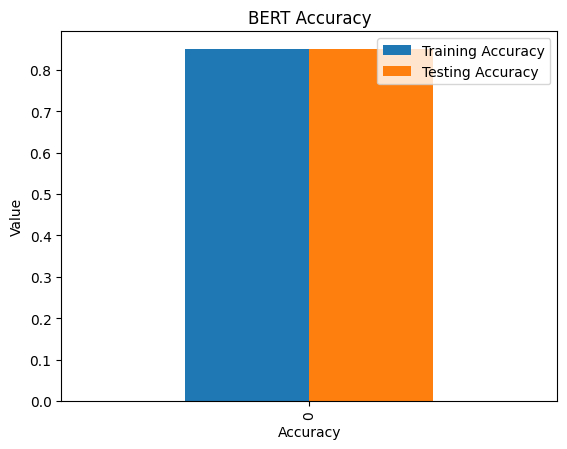

In [43]:


bert_acc_df=pd.DataFrame({"Training Accuracy":[result['acc']],"Testing Accuracy":[result['acc']]})
bert_acc_df.plot(kind='bar')

# Customize the labels and title
plt.xlabel('Accuracy')
plt.ylabel('Value')
plt.title('BERT Accuracy')

# Display the chart
plt.show()
